# Hook 教程
参考资料：
    [1]https://zhuanlan.zhihu.com/p/279903361
    [2]https://zhuanlan.zhihu.com/p/375811657
    [3]https://zhuanlan.zhihu.com/p/73868323

In [3]:
from tensorboardX import SummaryWriter


PyTorch 为每个张量或 nn.Module 对象注册 hook。hook 由对象的向前或向后传播触发。
    它们具有以下函数签名:

In [4]:
from torch import nn, Tensor

def module_hook(module: nn.Module, input: Tensor, output: Tensor):
    # For nn.Module objects only.
    pass
def tensor_hook(grad: Tensor):
    # For Tensor objects only.
    # Only executed during the *backward* pass!
    pass

### 例子1: 获得模型执行详情

In [5]:

class VerboseExecution(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

        # 模型的每一层都注册这个hook
        for name, layer in self.model.named_children():
            layer.__name__ = name
            #显然，这个表达式的意思是得到对应层的名字和输出向量的维度大小
            layer.register_forward_hook(
                lambda layer, _, output: print(f"{layer.__name__}{'output:',output.shape}")
            )

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

In [6]:
import torch
from torchvision.models import resnet50

# 以resnet50为例子
verbose_resnet = VerboseExecution(resnet50())


In [7]:
dummy_input = torch.ones(10, 3, 224, 224)

_ = verbose_resnet(dummy_input)

conv1('output:', torch.Size([10, 64, 112, 112]))
bn1('output:', torch.Size([10, 64, 112, 112]))
relu('output:', torch.Size([10, 64, 112, 112]))
maxpool('output:', torch.Size([10, 64, 56, 56]))
layer1('output:', torch.Size([10, 256, 56, 56]))
layer2('output:', torch.Size([10, 512, 28, 28]))
layer3('output:', torch.Size([10, 1024, 14, 14]))
layer4('output:', torch.Size([10, 2048, 7, 7]))
avgpool('output:', torch.Size([10, 2048, 1, 1]))
fc('output:', torch.Size([10, 1000]))


In [8]:
# 感兴趣的小伙伴可以按照相应的图结构计算一下
with SummaryWriter(logdir="network_visualization") as w:
    w.add_graph(verbose_resnet, dummy_input)

C:\Users\lenovo\.conda\envs\CLMLF\lib\site-packages\ipykernel_launcher.py:11: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  # This is added back by InteractiveShellApp.init_path()


conv1('output:', torch.Size([10, 64, 112, 112]))
bn1('output:', torch.Size([10, 64, 112, 112]))
relu('output:', torch.Size([10, 64, 112, 112]))
maxpool('output:', torch.Size([10, 64, 56, 56]))
layer1('output:', torch.Size([10, 256, 56, 56]))
layer2('output:', torch.Size([10, 512, 28, 28]))
layer3('output:', torch.Size([10, 1024, 14, 14]))
layer4('output:', torch.Size([10, 2048, 7, 7]))
avgpool('output:', torch.Size([10, 2048, 1, 1]))
fc('output:', torch.Size([10, 1000]))
conv1('output:', torch.Size([10, 64, 112, 112]))
bn1('output:', torch.Size([10, 64, 112, 112]))
relu('output:', torch.Size([10, 64, 112, 112]))
maxpool('output:', torch.Size([10, 64, 56, 56]))
layer1('output:', torch.Size([10, 256, 56, 56]))
layer2('output:', torch.Size([10, 512, 28, 28]))
layer3('output:', torch.Size([10, 1024, 14, 14]))
layer4('output:', torch.Size([10, 2048, 7, 7]))
avgpool('output:', torch.Size([10, 2048, 1, 1]))
fc('output:', torch.Size([10, 1000]))
conv1('output:', torch.Size([10, 64, 112, 112]))

## 示例 #2: 特征提取

In [9]:
from typing import Dict, Iterable, Callable

class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict( [*self.model.named_modules()] )[layer_id]
            layer.register_forward_hook(self.save_outputs_hook (layer_id) )

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        _ = self.model(x)
        return self._features

In [10]:
resnet_features = FeatureExtractor(resnet50(), layers=["layer4", "avgpool"])
features = resnet_features(dummy_input)

print({name: output.shape for name, output in features.items()})
# {'layer4': torch.Size([10, 2048, 7, 7]), 'avgpool': torch.Size([10, 2048, 1, 1])}

{'layer4': torch.Size([10, 2048, 7, 7]), 'avgpool': torch.Size([10, 2048, 1, 1])}


# 提取中间层

In [15]:
import torch
from torch.nn import Conv2d, Linear, AdaptiveAvgPool2d

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.layer1 = Linear(in_features=32, out_features=64)
        self.avgpool = AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.layer1(x)
        return x

model = Model()

'''
定义好模型后，假设我们提取 avgpool前的feature，即conv1后的feature：
'''
# -------------------- 第一步：定义接收feature的函数 ---------------------- #
# 这里定义了一个类，类有一个接收feature的函数hook_fun。定义类是为了方便提取多个中间层。
class HookTool:
    def __init__(self):
        self.fea = None

    def hook_fun(self, module, fea_in, fea_out):
        '''
        注意用于处理feature的hook函数必须包含三个参数[module, fea_in, fea_out]，参数的名字可以自己起，但其意义是
        固定的，第一个参数表示torch里的一个子module，比如Linear,Conv2d等，第二个参数是该module的输入，其类型是
        tuple；第三个参数是该module的输出，其类型是tensor。注意输入和输出的类型是不一样的，切记。
        '''
        self.fea = fea_out

# ---------- 第二步：注册hook，告诉模型我将在哪些层提取feature -------- #
def get_feas_by_hook(model):
    """
    提取Conv2d后的feature，我们需要遍历模型的module，然后找到Conv2d，把hook函数注册到这个module上；
    这就相当于告诉模型，我要在Conv2d这一层，用hook_fun处理该层输出的feature.
    由于一个模型中可能有多个Conv2d，所以我们要用hook_feas存储下来每一个Conv2d后的feature
    """
    fea_hooks = []
    for n, m in model.named_modules():
        if isinstance(m, torch.nn.Conv2d):
            cur_hook = HookTool()
            m.register_forward_hook(cur_hook.hook_fun)
            fea_hooks.append(cur_hook)

    return fea_hooks


fea_hooks = get_feas_by_hook(model) # 调用函数，完成注册即可

x  = torch.randn([32, 3, 224, 224])
out = model(x)
print('The number of hooks is:', len(fea_hooks))
print('The shape of the first Conv2D feature is:', fea_hooks[0].fea.shape)

The number of hooks is: 1
The shape of the first Conv2D feature is: torch.Size([32, 32, 222, 222])


In [17]:
import torch
from torchvision.models import resnet18
import torch.nn as nn
from torchvision import transforms

import matplotlib.pyplot as plt

def viz(module, input):
    x = input[0][0]
    #最多显示4张图
    min_num = np.minimum(4, x.size()[0])
    for i in range(min_num):
        plt.subplot(1, 4, i+1)
        plt.imshow(x[i].cpu())
    plt.show()




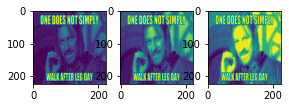

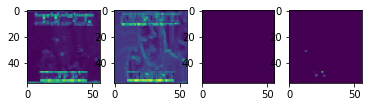

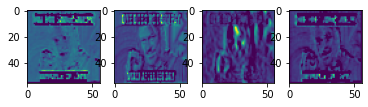

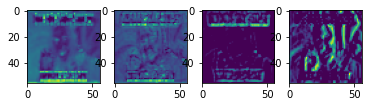

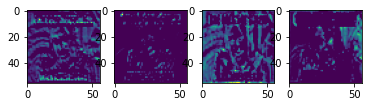

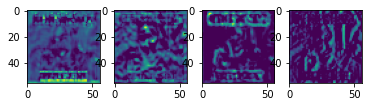

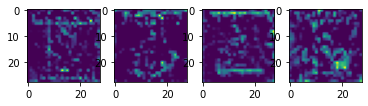

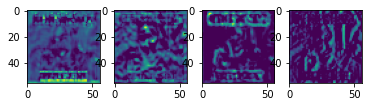

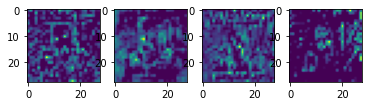

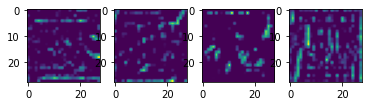

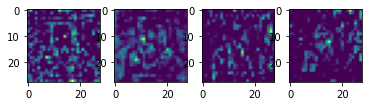

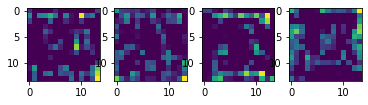

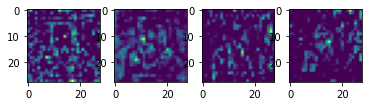

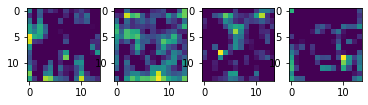

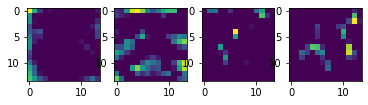

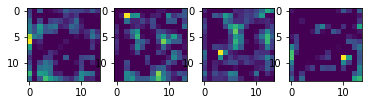

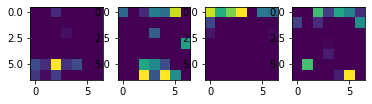

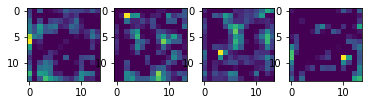

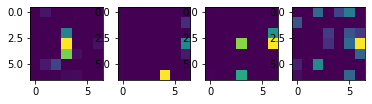

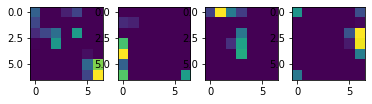

In [18]:
import cv2
import numpy as np
def main():
    t = transforms.Compose([transforms.ToPILImage(),
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])
                            ])

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = resnet18(pretrained=True).to(device)
    for name, m in model.named_modules():
        # if not isinstance(m, torch.nn.ModuleList) and \
        #         not isinstance(m, torch.nn.Sequential) and \
        #         type(m) in torch.nn.__dict__.values():
        # 这里只对卷积层的feature map进行显示
        if isinstance(m, torch.nn.Conv2d):
            m.register_forward_pre_hook(viz)
    img = cv2.imread('./1.jpg')
    img = t(img).unsqueeze(0).to(device)
    with torch.no_grad():
        model(img)

if __name__ == '__main__':
    main()